In [1]:
# import statsmodels.tsa as tsa
from pytisean import tiseano, tiseanio
# from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
# import subprocess


%matplotlib inline

# def autocorrelation(x): #todo flatten with mean
#     result = np.correlate(x,x,mode="full")
#     return result[result.size//2:result.size//2+30]

def autocorrelation(x): 
    result, msg = tiseanio('/home/luca/bin/autocor', data=x, silent=True)
    return result[:,1]

def powerspektrum(x):
    result, msg = tiseanio('/home/luca/bin/spectrum', data=x, silent=True)
    return result[:,0], result[:,1]


# henon, msg = tiseano('/home/luca/bin/henon', '-l5000', silent=True)


# fig1, ax1 = plt.subplots(1, 1)
# ax1.scatter(henon[:, 0], henon[:, 1], color='k', s=0.1)
# ax1.set_title('The Henon map')
# ax1.set_xlabel(r'$x$', fontsize=16)
# ax1.set_ylabel(r'$y$', fontsize=16)
# plt.show()

Null Hypothesis 
- simple vs. composite
  
Chaos vs. Noise
Typical realizations vs. Constraind realiszation


In [2]:
# # creating an AR2 Timeseries
parameter = np.array([1,0.33,0.5,1])
# ma = np.array([1])


# ar2_data = ArmaProcess(ar2,ma).generate_sample(nsample=9)
ar2_data, msg = tiseanio('/home/luca/bin/ar-run', '-l1000', '-p2', data=[1,0.33,0.5,1]
, silent=True)

# ar2_data, msg = tiseano('/home/luca/bin/ar-run', '-l1000', '-p2', '/home/luca/Documents/Repositories/Surrogates/ar3.txt'
# , silent=False)

# print(ar2_data)
# plt.title("Ar(2) generated time series")
# plt.plot(ar2_data)
# plt.show()

# autocorrelation(ar2_data)

# autcorr_ar2 = autocorrelation(ar2_data)
# plt.title("autocorrelation")
# plt.plot(autcorr_ar2)
# plt.show()

def plot_surrogates(time_series, surrogate_method):
    time_series_surrogate = surrogate_method(time_series)
    fig, axs = plt.subplots(4, )
    fig.set_size_inches(5,10)
    mean = np.mean(time_series)
    std = np.std(time_series)
    mean_surrogate = np.mean(time_series_surrogate)
    std_surrogate = np.std(time_series_surrogate)
    axs[0].set_title("Timeseries")
    axs[0].plot(time_series, label=f"Original: mean={mean:.2f}, std={std:.2f}")
    axs[0].plot(time_series_surrogate, label=f"Surrogate: mean={mean_surrogate:.2f}, std={std_surrogate:.2f}")
    axs[0].set_xlabel("time steps")
    axs[0].set_ylabel("value")
    axs[1].set_title("Autocorrelation")
    axs[1].plot(autocorrelation(time_series))
    axs[1].plot(autocorrelation(time_series_surrogate))
    axs[2].set_title("Power Spectrum")
    f, Pxx = powerspektrum(time_series) # calculate power spectrum
    axs[2].plot(f, Pxx)
    f_s, Pxx_s = powerspektrum(time_series_surrogate)
    axs[2].plot(f_s, Pxx_s)
    axs[2].set_xlabel("frequencys")
    axs[2].set_ylabel("power")
    axs[3].hist(time_series)
    axs[3].hist(time_series_surrogate)
    axs[3].set_xlabel("values")
    axs[3].set_ylabel("occurance")
    fig.legend()
    fig.tight_layout()
    plt.plot()
    return
    





Random Shuffle Surrogates (RS)

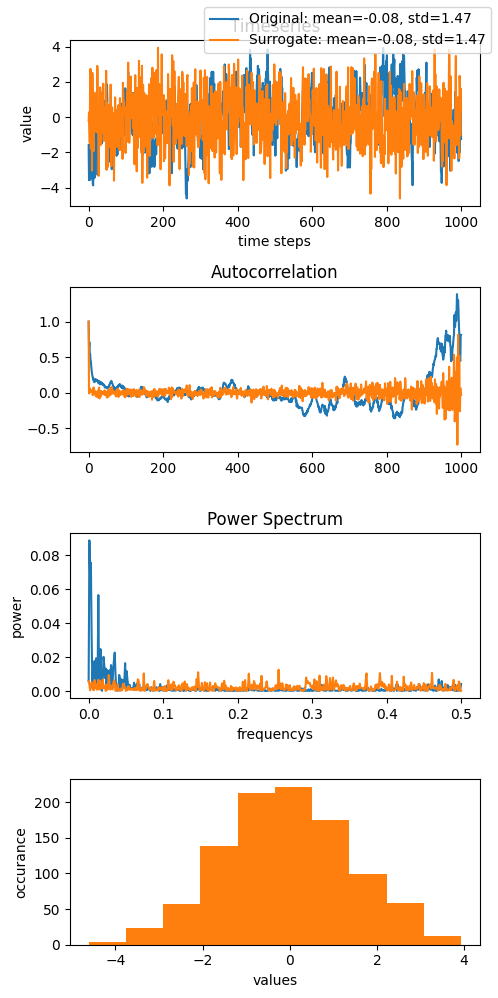

In [3]:
def RS(timeseries):
    """
        shuffles the values of the time series
    """
    RS_surrogate = np.copy(timeseries)
    np.random.shuffle(RS_surrogate)
    return RS_surrogate

plot_surrogates(ar2_data, RS)


### FT

Null Hypothesis: data come from linear gaussian prozess

- FFT
- random phases $\phi$ s.t. $\phi(f)=-\phi(-f)$ 
- IFFT



1000


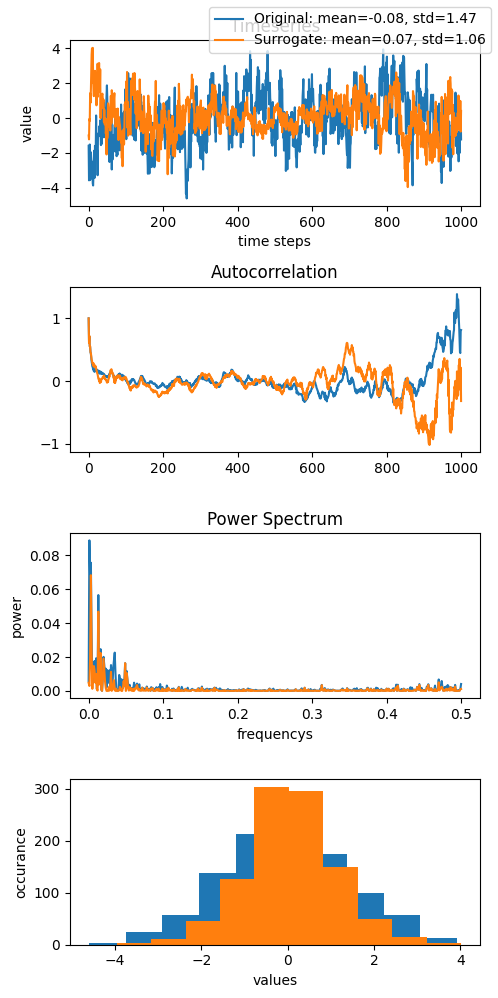

In [4]:
def FS_phase(timeseries):
    ft = np.fft.fft(timeseries)
    phase = np.angle(ft) #phase of the complex fourier values
    # print(np.imag(ft))
    amp = np.abs(ft) # amplitudes of the complex fourier values
    # print(amp)

    n = len(ft)
    print(n)
    # constrained that phi(f) = -phi(-f) that ifft is real
    if n % 2 == 0:
        half_phase = np.random.uniform(0,2*np.pi, n//2)
        phase = np.append(half_phase, -np.flip(half_phase))
    else:
        half_phase = np.random.uniform(0,2*np.pi, n//2+1)
        phase = np.append(0, np.append(half_phase[:-1], np.append([half_phase[-1]], -np.flip(half_phase[:-1]))))

    # amp
    # amp = np.append(0,amp)
    value = np.fft.ifft( amp* np.exp(phase*1j))
    # print(value)
    return np.real(value) # todo img actually not zero

plot_surrogates(ar2_data, FS_phase)

### AAFT

Null Hypothesis:
underlaying time series $\{y_i\}$ consistent with the null hypothesis of linear gaussian noise. The observed time series $\{x_i\}$ is given by $x_i = h(y_i)$. Monotonic nonlinear transformation of a linear gaussian process.

- rescale values to be gaussian
- apply FT (same Fourier spectrum)
- rescale back to have same amplitude distribution

[ 8.03949633e-01  1.35286340e+00  2.56913115e-01 -1.10627553e+00
  2.27224632e-01  3.77015981e-01  1.11294012e+00 -2.29869921e-01
  1.09055951e+00 -5.36172031e-01 -5.67120824e-01  1.11426556e+00
 -9.89045349e-01 -1.00155358e+00 -5.28947641e-02  1.68334639e+00
 -7.04988402e-01  2.13385677e-01  1.08043159e+00  4.99224152e-01
 -4.97405224e-01 -5.89044055e-01  3.34431952e-01 -1.75590014e+00
  1.19988110e+00 -1.25079932e+00 -7.39519949e-01 -4.43199409e-01
 -7.60881391e-01 -6.08645395e-01  2.31375814e-01 -3.75699053e-02
 -6.70829422e-01  7.75686866e-01  8.85021921e-01  8.47165380e-01
  8.03114256e-01  1.04423494e+00  9.61423611e-01  1.29734187e+00
 -8.71051415e-01 -8.16056085e-01  1.63385089e+00 -5.15595242e-02
 -1.49146406e+00  1.32718797e+00 -4.99087166e-01  2.28447004e+00
 -1.41290551e+00 -2.40887327e-01 -9.47796744e-01 -6.76815713e-02
 -1.83323886e+00 -3.23082701e-01  9.57840807e-01 -7.82149714e-01
 -4.84444966e-01 -3.77745288e-01 -7.41212279e-01 -3.30844629e-01
 -2.65076192e-02 -6.83330

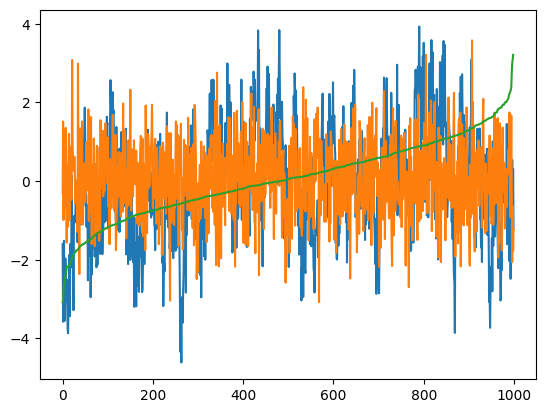

In [5]:
def AAFT(timeseries):
    n = len(timeseries)

    # print(timeseries)
    y = np.random.normal(0,1,n)
    print(y)
    # plt.plot(y)
    indices = np.argsort(timeseries)
    plt.plot(timeseries)
    y = y[indices]
    plt.plot(y)
    # plt.hist(y)
    # print(y[indices])

    sorted_timeseries = np.sort(timeseries)

    y = y[np.argsort(y)[:-1]] 
    print(y)
    plt.plot(y)
    # print(y)

AAFT(ar2_data)

### IAAFT

Share distribution and power spectrum

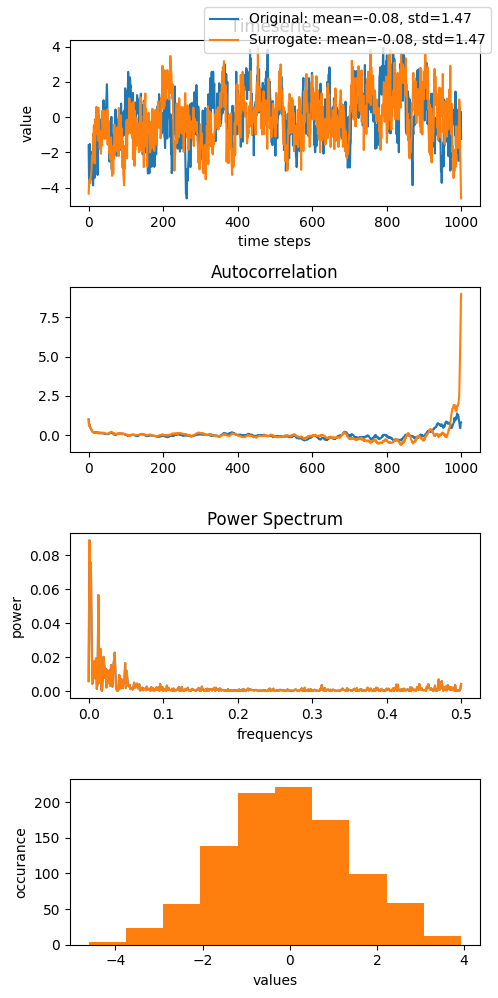

In [6]:
def IAAFT(timeseries):
    IAAFT_surr, msg = tiseanio('/home/luca/bin/surrogates', silent=True, data=timeseries)
    # print(IAAFT_surr)
    return IAAFT_surr

plot_surrogates(ar2_data, IAAFT)